# `012` Recurrent Neural Networks

Requirements: 007 Initialization, 008 Batch normalization

**⚠️⚠️⚠️ This notebook is still under construction, there's some random bug I haven't isolated yet. ⚠️⚠️⚠️**

All the models described until now are what it's called feedforward neural networks. This means that the information always flows in one direction, from the input to the output. However, there are some problems that require a different approach. For example, when the input is a variable-length sequence, like text or time series, we need a model that can handle this kind of data. **Recurrent Neural Networks** (RNNs) are a type of neural network that was invented in the 1970s inspired in the Ising model of statistical mechanics. The idea is to have:
* Have a hidden state that is updated at each time step
* Use the hidden state to make predictions

Let's implement a very minimal RNN to see how this can work in practice. We will be using a dataset of names from different countries, and we will train the RNN to predict from which country a name is.

In [1]:
from json import loads
from matplotlib import pyplot as plt
from random import shuffle
import torch

In [2]:
with open('custom-data/names.json', encoding='utf-8') as f:
	data = loads(f.read().lower())

nationalities = list(data.keys())
characters = {c for names in data.values() for name in names for c in name}
c2i = {c: i for i, c in enumerate(characters)}
i2c = {i: c for i, c in enumerate(characters)}

X, Y = [], []
for nationality, names in data.items():
	for name in names:
		X.append(torch.tensor([c2i[c] for c in name]))
		Y.append(nationalities.index(nationality))

indices = list(range(len(X)))
shuffle(indices)
X = [X[i] for i in indices]
Y = torch.tensor([Y[i] for i in indices])

print(f'Loaded {len(X)} names from {len(nationalities)} nationalities using {len(characters)} different characters')
print(X[0], Y[0], '->', ''.join(i2c[i.item()] for i in X[0]), nationalities[Y[0]])

Loaded 20074 names from 18 nationalities using 58 different characters
tensor([37,  0, 25,  0, 34, 40, 10,  2,  0, 42]) tensor(14) -> getelmaher russian


Now let's define the RNN. There are so many ways to arbitrarily define a RNN, but we will use the following:
* Initially, the hidden state is a vector of zeros.
* At each time step, we will first transform the hidden state using a linear transformation.
* Then, we will also apply a linear transformation to the input.
* After that, the new hidden state is the sum of the transformed hidden state and the transformed input, passed through a non-linear activation function.
* Finally, we make our prediction using a linear transformation of the final hidden state, and then applying $log(sofmax(x))$ to get the probabilities.

The choose of activation function is just to show that we can use any activation function we want, not just ReLU all the time like we have been doing. The architecture could be changed in different ways such as concatenating the input and the hidden state before applying a linear transformation, using multiple hidden states, etc.

In [3]:
class RNN(torch.nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(RNN, self).__init__()
		self.hidden_size = hidden_size
		self.one_hot = torch.eye(input_size)
		self.i2h = torch.nn.Linear(input_size, hidden_size)
		self.h2h = torch.nn.Linear(hidden_size, hidden_size)
		self.h2o = torch.nn.Linear(hidden_size, output_size)

	def forward(self, input):
		hidden = torch.zeros(1, self.hidden_size)
		for i in input:
			h = self.h2h(hidden)
			i = self.i2h(self.one_hot[i])
			hidden = (h + i).tanh()
		return self.h2o(hidden).log_softmax(1)

model = RNN(len(characters), 256, len(nationalities))
print(f'Created model with {sum(p.numel() for p in model.parameters())} parameters')

Created model with 85522 parameters


Now let's train our model. Since every name has a different length, we can't leverage pytorch's capabilities of processing in parallel many examples in a minibatch.

Epoch 0 loss: 2.8539445400238037
Epoch 10000 loss: 8.4652681350708
Epoch 20000 loss: 1.2149609327316284
Epoch 30000 loss: 0.02708055078983307
Epoch 40000 loss: 0.15825799107551575
Epoch 50000 loss: 1.3978327512741089
Epoch 60000 loss: 18.141559600830078
Epoch 70000 loss: 0.16582004725933075
Epoch 80000 loss: 0.013612068258225918
Epoch 90000 loss: 0.532650887966156


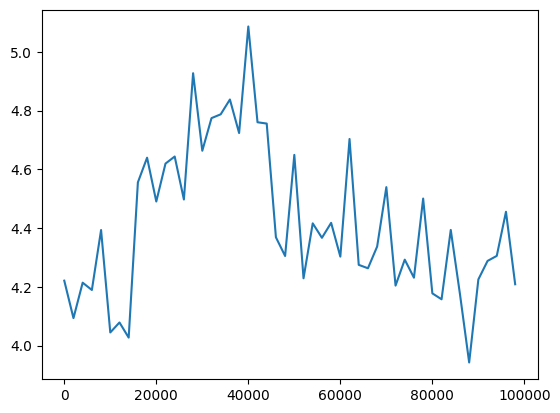

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
losses = []
for epoch in range(100000):
	ix = torch.randint(len(X), (1,)).item()
	x, y = X[ix], Y[ix]
	output = model(x)
	loss = criterion(output.view(1, -1), y.view(1))
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	losses.append(loss.item())
	if epoch % 10000 == 0:
		print(f'Epoch {epoch} loss: {loss.item()}')
plt.plot(range(0, 100000, 2000), torch.tensor(losses).view(-1, 2000).mean(1));

You can see how the training is much longer than with the previous models, and judging by the loss it seems that the model could even use more training. Since we are not using any kind of layer normalization, this model is very sensitive to vanishing or exploding gradients. Let's see how the gradients of the model look like.

In [5]:
model.h2h.weight.grad.abs().mean(), model.i2h.weight.grad.abs().mean(), model.h2o.weight.grad.abs().mean()

(tensor(0.), tensor(0.), tensor(0.1011))

The folklore says that average gradients less than $10^{-3}$ are prone to be having a vanishing problem, which looks like our case. We should test it more thoroughly by following the average update of the weights, but we will leave this for another time. If this is already a problem with short sentences like names, imagine with longer sequences like text. In the following notebooks we will explore a solution to this problem. For now, let's just test a bit what we have.

In [6]:
for name in 'carlos', 'dimitri', 'mohammed', 'satoshi':
	print(name)
	name_ix = [c2i[c] for c in name]
	probs = model(name_ix)[0]
	top = torch.topk(probs, 3)
	for i in range(3):
		print(f'\t{nationalities[top.indices[i]]}: {top.values[i].exp().item()*100:.2f}%')

carlos
	english: 36.62%
	italian: 33.23%
	russian: 17.03%
dimitri
	english: 36.62%
	italian: 33.23%
	russian: 17.03%
mohammed
	english: 36.62%
	italian: 33.23%
	russian: 17.03%
satoshi
	english: 36.62%
	italian: 33.23%
	russian: 17.03%
